RETRIEVAL RECALL ANALYSIS
Loaded 4000 claims from original HoVer file
Loaded 4000 claims from retrieval file

Processed claims with supporting facts: 4000
Average supporting docs per claim: 2.98

Top-K      Avg Recall      Coverage (All)       Coverage (Any)      
1          17.5            0.0                  46.8                
5          32.7            8.4                  64.6                
10         37.6            11.0                 70.7                
20         42.1            13.8                 76.1                
50         47.5            16.9                 81.5                
100        51.7            19.8                 85.5                

TOP-10 vs TOP-100 ANALYSIS
Average Recall@10:  37.6%
Average Recall@100: 51.7%
Recall Loss (using top-10 instead of top-100): 14.2%

Coverage@10 (all docs found):  11.0%
Coverage@100 (all docs found): 19.8%
Coverage Loss: 8.8%

RANK DISTRIBUTION OF SUPPORTING DOCUMENTS
Rank 1-5            : 3538 ( 29.7%)
Rank 6-10     

/tmp/ipython-input-3900521765.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_to_plot, labels=['1', '5', '10', '20', '50', '100'],



✅ Plots saved to 'retrieval_recall_analysis.png'


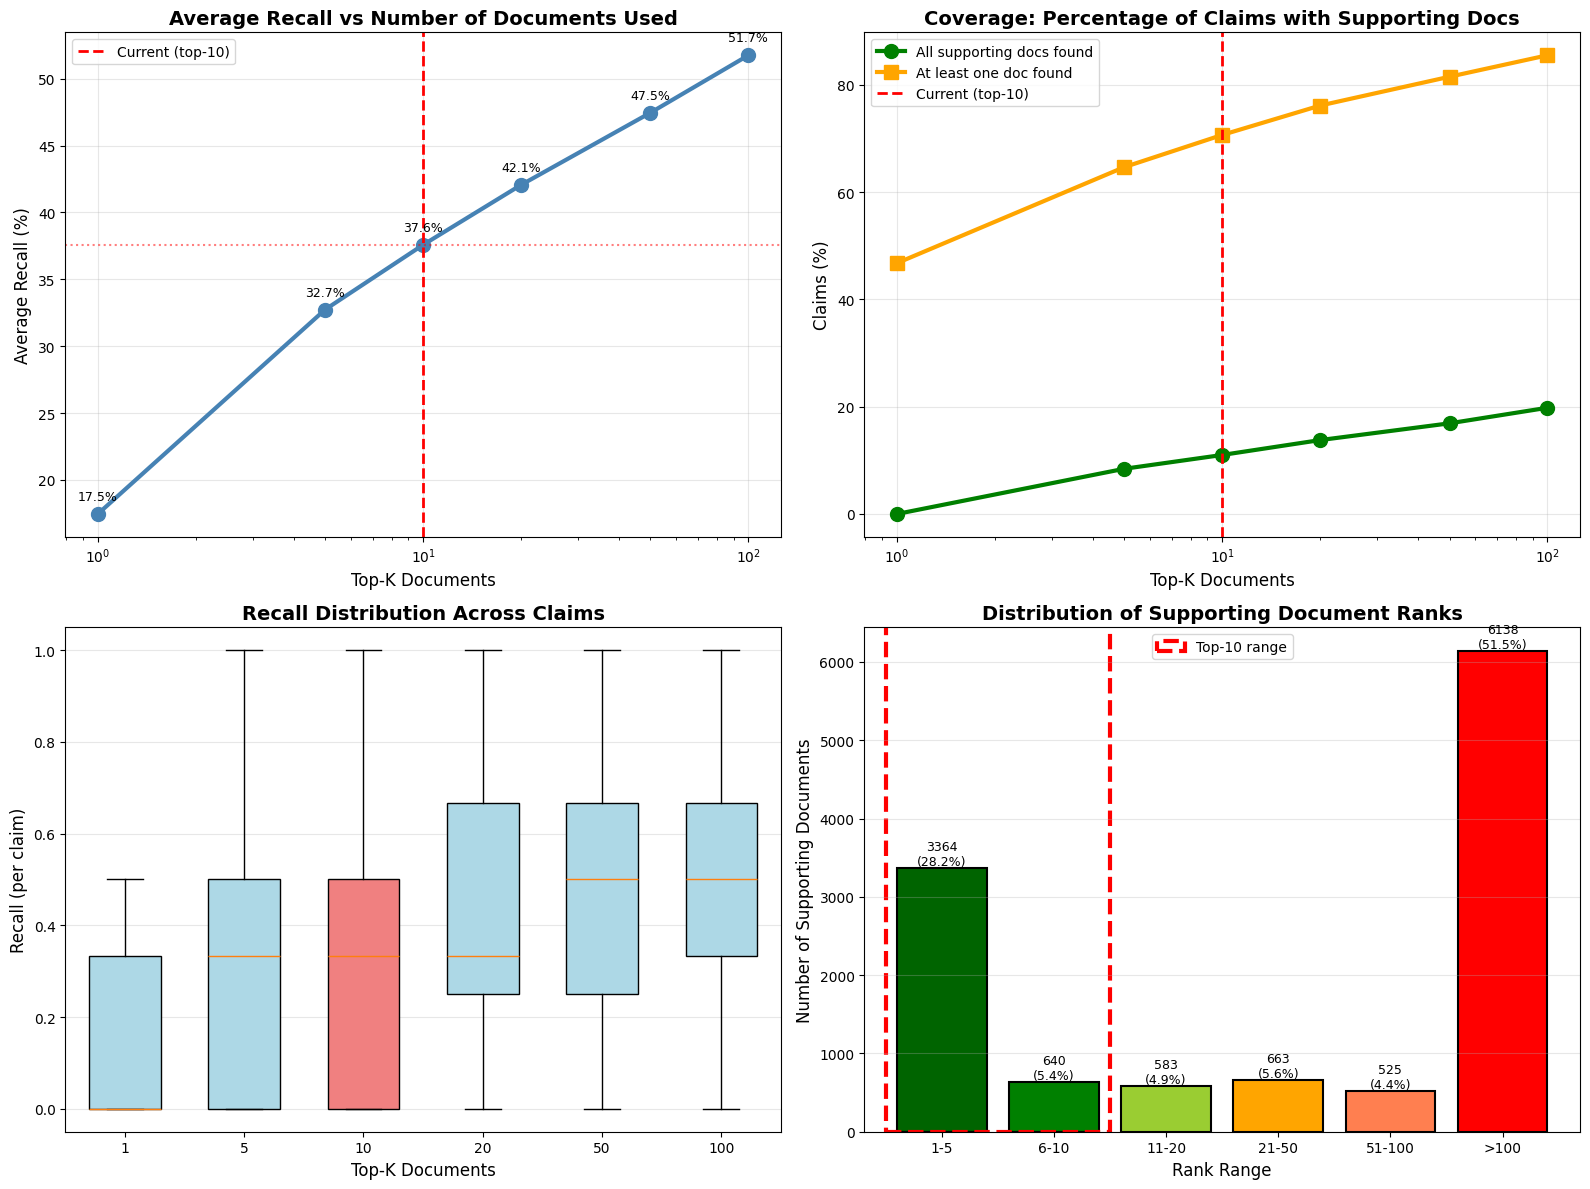


VERIFICATION ACCURACY vs RETRIEVAL RECALL

Recall@10 Range      Claims     Accuracy       
--------------------------------------------------
[0.0, 0.2)           1174       52.4           %
[0.2, 0.5)           1144       48.8           %
[0.5, 0.8)           1242       49.4           %
[1.0]                440        55.5           %

✅ Plot saved to 'verification_vs_retrieval_quality.png'


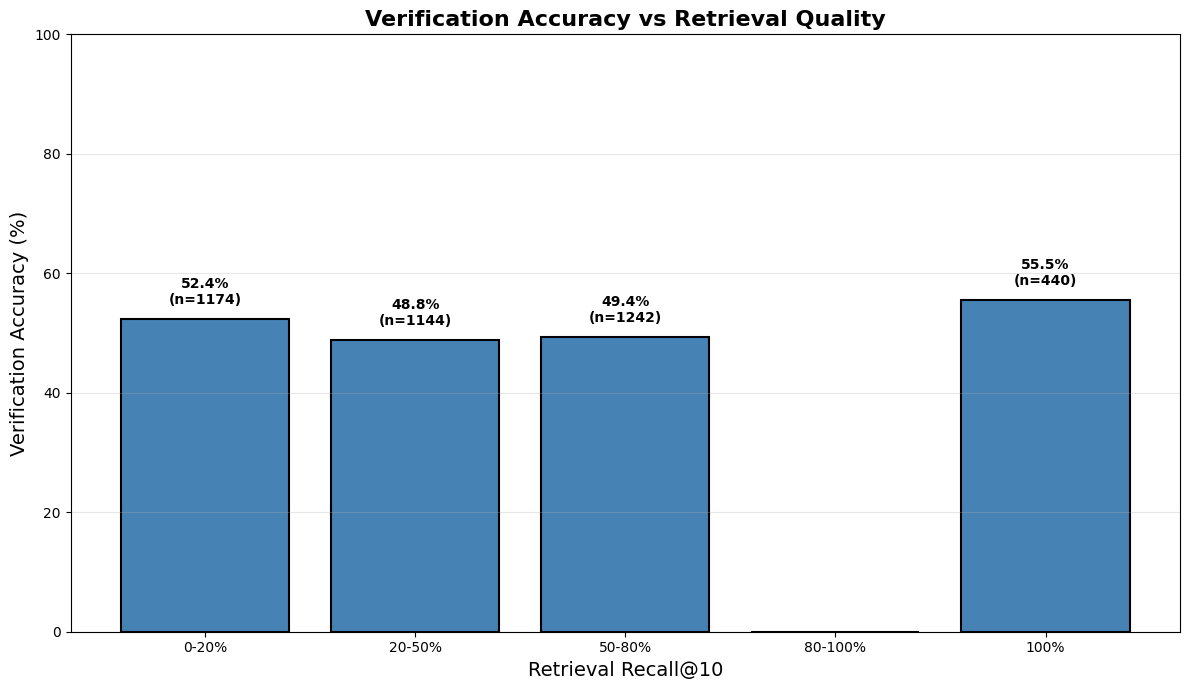

In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

def analyze_retrieval_recall(retrieval_file, original_hover_file):
    """
    Analyze recall at different top-k values (1, 5, 10, 20, 50, 100)
    Shows if limiting to top-10 docs hurts performance
    """

    print("="*80)
    print("RETRIEVAL RECALL ANALYSIS")
    print("="*80)

    # Load retrieval results
    with open(retrieval_file, 'r') as f:
        retrieval_data = json.load(f)

    # Load original HoVer data with supporting facts
    with open(original_hover_file, 'r') as f:
        hover_list = json.load(f)

    # Convert list to dictionary keyed by uid
    hover_data = {}
    for item in hover_list:
        uid = item.get('uid')
        if uid:
            hover_data[uid] = item

    print(f"Loaded {len(hover_data)} claims from original HoVer file")
    print(f"Loaded {len(retrieval_data)} claims from retrieval file")

    # Analysis storage
    recalls_by_k = {k: [] for k in [1, 5, 10, 20, 50, 100]}
    total_supporting_docs = []
    found_at_rank = []  # Track at what rank each supporting doc was found

    claims_with_all_docs = {k: 0 for k in [1, 5, 10, 20, 50, 100]}
    claims_with_any_docs = {k: 0 for k in [1, 5, 10, 20, 50, 100]}

    # Process each claim
    processed = 0
    for claim_uid, retrieval_info in retrieval_data.items():
        # Get supporting facts from original data
        hover_item = hover_data.get(claim_uid, {})
        supporting_facts = hover_item.get('supporting_facts', [])

        if not supporting_facts:
            continue

        processed += 1

        # Extract gold document titles
        gold_titles = set([fact[0] for fact in supporting_facts])
        total_supporting_docs.append(len(gold_titles))

        # Get retrieved document titles
        retrieved_docs = retrieval_info.get('retrieved_docs', [])

        # Check recall at different k values
        for k in [1, 5, 10, 20, 50, 100]:
            top_k_titles = set([doc['title'] for doc in retrieved_docs[:k]])

            # Calculate recall
            found = len(gold_titles & top_k_titles)
            recall = found / len(gold_titles) if gold_titles else 0
            recalls_by_k[k].append(recall)

            # Track coverage
            if found == len(gold_titles):
                claims_with_all_docs[k] += 1
            if found > 0:
                claims_with_any_docs[k] += 1

        # Track rank of each supporting doc
        retrieved_titles = [doc['title'] for doc in retrieved_docs]
        for gold_title in gold_titles:
            if gold_title in retrieved_titles:
                rank = retrieved_titles.index(gold_title) + 1
                found_at_rank.append(rank)
            else:
                found_at_rank.append(101)  # Not in top-100

    num_claims = processed

    print(f"\nProcessed claims with supporting facts: {num_claims}")
    print(f"Average supporting docs per claim: {np.mean(total_supporting_docs):.2f}")
    print(f"\n{'='*80}")
    print(f"{'Top-K':<10} {'Avg Recall':<15} {'Coverage (All)':<20} {'Coverage (Any)':<20}")
    print(f"{'='*80}")

    for k in [1, 5, 10, 20, 50, 100]:
        avg_recall = np.mean(recalls_by_k[k]) * 100
        all_coverage = (claims_with_all_docs[k] / num_claims) * 100
        any_coverage = (claims_with_any_docs[k] / num_claims) * 100

        print(f"{k:<10} {avg_recall:<15.1f} {all_coverage:<20.1f} {any_coverage:<20.1f}")

    # Specific comparison: top-10 vs top-100
    print(f"\n{'='*80}")
    print("TOP-10 vs TOP-100 ANALYSIS")
    print(f"{'='*80}")

    recall_10 = np.mean(recalls_by_k[10]) * 100
    recall_100 = np.mean(recalls_by_k[100]) * 100
    recall_loss = recall_100 - recall_10

    print(f"Average Recall@10:  {recall_10:.1f}%")
    print(f"Average Recall@100: {recall_100:.1f}%")
    print(f"Recall Loss (using top-10 instead of top-100): {recall_loss:.1f}%")

    coverage_10 = (claims_with_all_docs[10] / num_claims) * 100
    coverage_100 = (claims_with_all_docs[100] / num_claims) * 100
    coverage_loss = coverage_100 - coverage_10

    print(f"\nCoverage@10 (all docs found):  {coverage_10:.1f}%")
    print(f"Coverage@100 (all docs found): {coverage_100:.1f}%")
    print(f"Coverage Loss: {coverage_loss:.1f}%")

    # Distribution analysis
    print(f"\n{'='*80}")
    print("RANK DISTRIBUTION OF SUPPORTING DOCUMENTS")
    print(f"{'='*80}")

    rank_bins = [(1, 5), (6, 10), (11, 20), (21, 50), (51, 100), (101, 101)]
    for low, high in rank_bins:
        if low == 101:
            count = sum(1 for r in found_at_rank if r > 100)
            label = "Not in top-100"
        else:
            count = sum(1 for r in found_at_rank if low <= r <= high)
            label = f"Rank {low}-{high}"

        percentage = (count / len(found_at_rank)) * 100 if found_at_rank else 0
        print(f"{label:<20}: {count:4d} ({percentage:5.1f}%)")

    # Visualization
    create_recall_plots(recalls_by_k, claims_with_all_docs, claims_with_any_docs,
                       num_claims, found_at_rank)

    return recalls_by_k, found_at_rank


def create_recall_plots(recalls_by_k, coverage_all, coverage_any, num_claims, ranks):
    """Create comprehensive visualization of retrieval analysis"""

    fig, axes = plt.subplots(2, 2, figsize=(16, 12))

    # Plot 1: Average Recall vs Top-K
    ax1 = axes[0, 0]
    k_values = [1, 5, 10, 20, 50, 100]
    avg_recalls = [np.mean(recalls_by_k[k]) * 100 for k in k_values]

    ax1.plot(k_values, avg_recalls, 'o-', linewidth=3, markersize=10, color='steelblue')
    ax1.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Current (top-10)')
    ax1.axhline(y=avg_recalls[2], color='red', linestyle=':', alpha=0.5)
    ax1.set_xlabel('Top-K Documents', fontsize=12)
    ax1.set_ylabel('Average Recall (%)', fontsize=12)
    ax1.set_title('Average Recall vs Number of Documents Used', fontsize=14, fontweight='bold')
    ax1.grid(True, alpha=0.3)
    ax1.legend(fontsize=10)
    ax1.set_xscale('log')

    # Add value labels
    for k, recall in zip(k_values, avg_recalls):
        ax1.annotate(f'{recall:.1f}%', xy=(k, recall),
                    xytext=(0, 10), textcoords='offset points',
                    ha='center', fontsize=9)

    # Plot 2: Coverage (All Docs Found)
    ax2 = axes[0, 1]
    coverage_all_pct = [(coverage_all[k] / num_claims) * 100 for k in k_values]
    coverage_any_pct = [(coverage_any[k] / num_claims) * 100 for k in k_values]

    ax2.plot(k_values, coverage_all_pct, 'o-', linewidth=3, markersize=10,
            color='green', label='All supporting docs found')
    ax2.plot(k_values, coverage_any_pct, 's-', linewidth=3, markersize=10,
            color='orange', label='At least one doc found')
    ax2.axvline(x=10, color='red', linestyle='--', linewidth=2, label='Current (top-10)')
    ax2.set_xlabel('Top-K Documents', fontsize=12)
    ax2.set_ylabel('Claims (%)', fontsize=12)
    ax2.set_title('Coverage: Percentage of Claims with Supporting Docs', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)
    ax2.legend(fontsize=10)
    ax2.set_xscale('log')

    # Plot 3: Recall Distribution (Box Plot)
    ax3 = axes[1, 0]
    data_to_plot = [recalls_by_k[k] for k in [1, 5, 10, 20, 50, 100]]
    bp = ax3.boxplot(data_to_plot, labels=['1', '5', '10', '20', '50', '100'],
                     patch_artist=True, widths=0.6)

    # Color the boxes
    colors = ['lightblue'] * len(bp['boxes'])
    colors[2] = 'lightcoral'  # Highlight top-10
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)

    ax3.set_xlabel('Top-K Documents', fontsize=12)
    ax3.set_ylabel('Recall (per claim)', fontsize=12)
    ax3.set_title('Recall Distribution Across Claims', fontsize=14, fontweight='bold')
    ax3.grid(True, alpha=0.3, axis='y')

    # Plot 4: Rank Distribution of Supporting Docs
    ax4 = axes[1, 1]

    if ranks:
        # Create histogram bins
        bins = [0, 5, 10, 20, 50, 100, 105]
        hist, _ = np.histogram(ranks, bins=bins)

        labels = ['1-5', '6-10', '11-20', '21-50', '51-100', '>100']
        colors_hist = ['darkgreen', 'green', 'yellowgreen', 'orange', 'coral', 'red']

        bars = ax4.bar(range(len(labels)), hist, color=colors_hist, edgecolor='black', linewidth=1.5)
        ax4.set_xlabel('Rank Range', fontsize=12)
        ax4.set_ylabel('Number of Supporting Documents', fontsize=12)
        ax4.set_title('Distribution of Supporting Document Ranks', fontsize=14, fontweight='bold')
        ax4.set_xticks(range(len(labels)))
        ax4.set_xticklabels(labels)
        ax4.grid(True, alpha=0.3, axis='y')

        # Add value labels on bars
        for bar, h in zip(bars, hist):
            height = bar.get_height()
            if h > 0:
                ax4.text(bar.get_x() + bar.get_width()/2., height,
                        f'{int(h)}\n({h/len(ranks)*100:.1f}%)',
                        ha='center', va='bottom', fontsize=9)

        # Add rectangle to highlight top-10
        rect = plt.Rectangle((-0.5, 0), 2, max(hist)*1.1,
                            linewidth=3, edgecolor='red', facecolor='none',
                            linestyle='--', label='Top-10 range')
        ax4.add_patch(rect)
        ax4.legend(fontsize=10)

    plt.tight_layout()
    plt.savefig('retrieval_recall_analysis.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Plots saved to 'retrieval_recall_analysis.png'")
    plt.show()


def compare_verification_by_recall(retrieval_file, original_hover_file, verification_file):
    """
    Analyze if verification accuracy correlates with retrieval recall
    """
    print(f"\n{'='*80}")
    print("VERIFICATION ACCURACY vs RETRIEVAL RECALL")
    print(f"{'='*80}")

    # Load all data
    with open(retrieval_file, 'r') as f:
        retrieval_data = json.load(f)

    with open(original_hover_file, 'r') as f:
        hover_list = json.load(f)

    # Convert to dict
    hover_data = {item['uid']: item for item in hover_list if 'uid' in item}

    with open(verification_file, 'r') as f:
        verification_data = json.load(f)

    # Analyze by recall bins
    recall_bins = [(0.0, 0.2), (0.2, 0.5), (0.5, 0.8), (0.8, 1.0), (1.0, 1.01)]

    results_by_bin = {bin_range: {'correct': 0, 'total': 0} for bin_range in recall_bins}

    for claim_uid, verif in verification_data.items():
        hover_item = hover_data.get(claim_uid, {})
        supporting_facts = hover_item.get('supporting_facts', [])

        if not supporting_facts:
            continue

        # Calculate recall@10 for this claim
        gold_titles = set([fact[0] for fact in supporting_facts])
        retrieved_docs = retrieval_data[claim_uid]['retrieved_docs']
        top_10_titles = set([doc['title'] for doc in retrieved_docs[:10]])

        found = len(gold_titles & top_10_titles)
        recall = found / len(gold_titles)

        # Check if verification was correct
        is_correct = (verif['predicted_label'] == verif['true_label'])

        # Assign to bin
        for bin_range in recall_bins:
            if bin_range[0] <= recall < bin_range[1]:
                results_by_bin[bin_range]['total'] += 1
                if is_correct:
                    results_by_bin[bin_range]['correct'] += 1
                break

    # Print results
    print(f"\n{'Recall@10 Range':<20} {'Claims':<10} {'Accuracy':<15}")
    print("-" * 50)

    for bin_range in recall_bins:
        results = results_by_bin[bin_range]
        if results['total'] > 0:
            accuracy = (results['correct'] / results['total']) * 100
            label = f"[{bin_range[0]:.1f}, {bin_range[1]:.1f})"
            if bin_range[1] > 1.0:
                label = "[1.0]"
            print(f"{label:<20} {results['total']:<10} {accuracy:<15.1f}%")

    # Visualization
    fig, ax = plt.subplots(figsize=(12, 7))

    labels = ['0-20%', '20-50%', '50-80%', '80-100%', '100%']
    accuracies = []
    counts = []

    for i, bin_range in enumerate(recall_bins):
        results = results_by_bin[bin_range]
        if results['total'] > 0:
            acc = (results['correct'] / results['total']) * 100
            accuracies.append(acc)
            counts.append(results['total'])
        else:
            accuracies.append(0)
            counts.append(0)

    bars = ax.bar(labels, accuracies, color='steelblue', edgecolor='black', linewidth=1.5)
    ax.set_xlabel('Retrieval Recall@10', fontsize=14)
    ax.set_ylabel('Verification Accuracy (%)', fontsize=14)
    ax.set_title('Verification Accuracy vs Retrieval Quality', fontsize=16, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim(0, 100)

    # Add value labels
    for bar, acc, count in zip(bars, accuracies, counts):
        if count > 0:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height + 2,
                   f'{acc:.1f}%\n(n={count})',
                   ha='center', va='bottom', fontsize=10, fontweight='bold')

    plt.tight_layout()
    plt.savefig('verification_vs_retrieval_quality.png', dpi=300, bbox_inches='tight')
    print(f"\n✅ Plot saved to 'verification_vs_retrieval_quality.png'")
    plt.show()


# Run it
recalls, ranks = analyze_retrieval_recall(
    retrieval_file='/content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_bm25_top100.json',
    original_hover_file='/content/hover_dev_release_v1.1.json'
)

compare_verification_by_recall(
    retrieval_file='/content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_bm25_top100.json',
    original_hover_file='/content/hover_dev_release_v1.1.json',
    verification_file='/content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_verified_aggregated.json'
)

RETRIEVAL RECALL ANALYSIS
Loaded 4000 claims from original HoVer file
Loaded 4000 claims from retrieval file

Processed claims with supporting facts: 4000
Average supporting docs per claim: 2.98

Top-K      Avg Recall      Coverage (All)       Coverage (Any)      
1          24.1            0.0                  66.0                
5          42.6            11.1                 82.0                
10         46.9            14.9                 84.0                
20         49.8            18.2                 85.0                
50         51.3            19.5                 85.5                
100        51.7            19.8                 85.5                

TOP-10 vs TOP-100 ANALYSIS
Average Recall@10:  46.9%
Average Recall@100: 51.7%
Recall Loss (using top-10 instead of top-100): 4.9%

Coverage@10 (all docs found):  14.9%
Coverage@100 (all docs found): 19.8%
Coverage Loss: 4.9%

RANK DISTRIBUTION OF SUPPORTING DOCUMENTS
Rank 1-5            : 4728 ( 39.7%)
Rank 6-10      

/tmp/ipython-input-1930346206.py:191: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  bp = ax3.boxplot(data_to_plot, labels=['1', '5', '10', '20', '50', '100'],



✅ Plots saved to 'retrieval_recall_analysis.png'


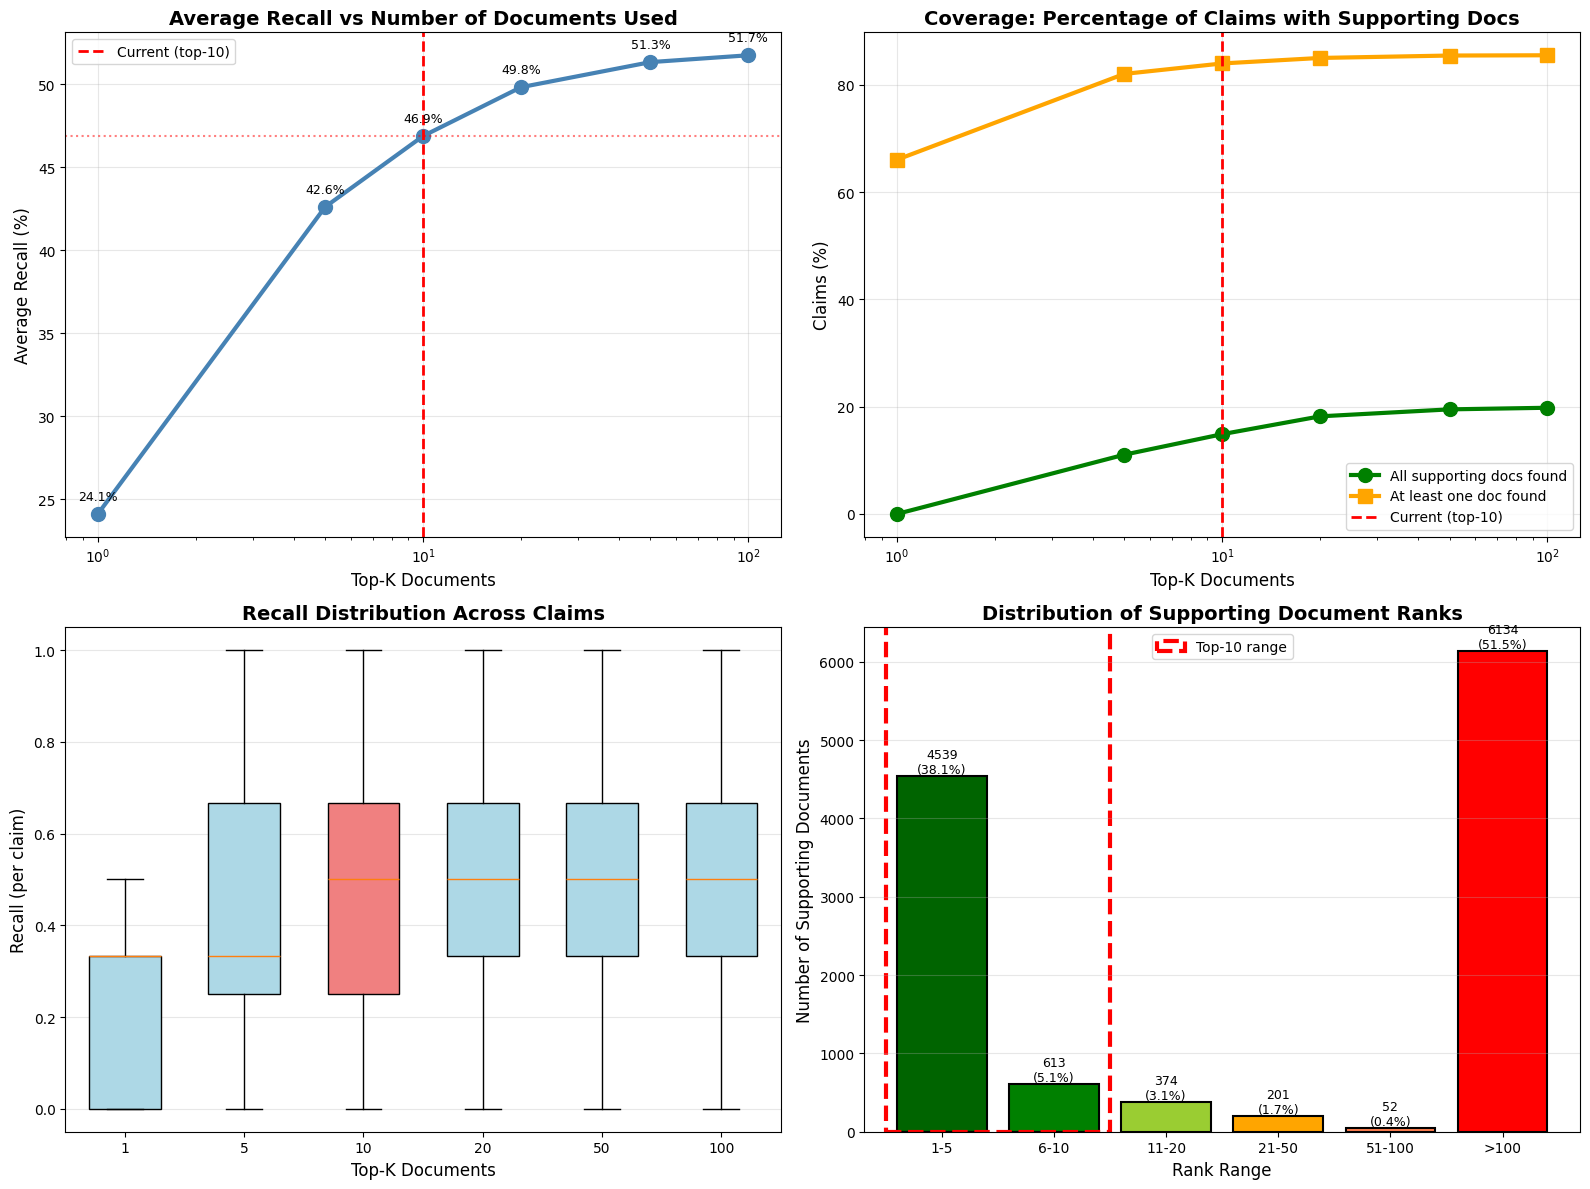


VERIFICATION ACCURACY vs RETRIEVAL RECALL

Recall@10 Range      Claims     Accuracy       
--------------------------------------------------
[0.0, 0.2)           641        54.1           %
[0.2, 0.5)           1182       49.6           %
[0.5, 0.8)           1582       48.7           %
[1.0]                595        54.8           %

✅ Plot saved to 'verification_vs_retrieval_quality.png'


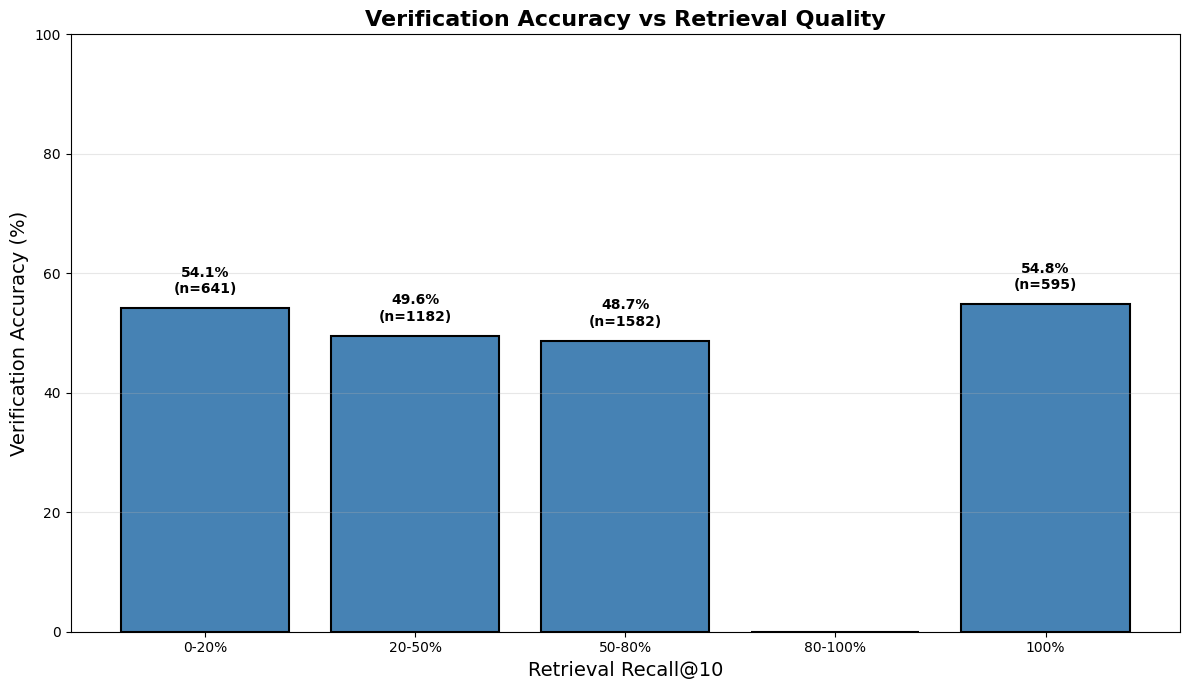

In [ ]:
# Run it
recalls, ranks = analyze_retrieval_recall(
    retrieval_file='/content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_dense_reranked_top100.json',
    original_hover_file='/content/hover_dev_release_v1.1.json'
)

compare_verification_by_recall(
    retrieval_file='/content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_dense_reranked_top100.json',
    original_hover_file='/content/hover_dev_release_v1.1.json',
    verification_file='/content/drive/MyDrive/CS_6120_NLP/Project/output/hover_dev_verified_aggregated.json'
)